In [2]:
%matplotlib inline
# %matplotlib notebook
import h5py
import rasterio
import rasterio.plot 
from shapely.geometry import box
import geopandas as gpd
from rasterio.mask import mask
import pandas as pd
import numpy as np
#usar opencv3 para evitar conflictos con rasterio
import cv2 
import os
import utilidades
import scipy
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import datetime

In [3]:
cwd = os.getcwd()
# print(cwd)

/media/daniel/Respaldo/Memoria/Codigo/AraucoNursery


In [5]:
os.chdir(cwd)
# os.chdir('D:/Memoria/Codigo/AraucoNursery/')
url_imagen = "PROYECTOS/CONTEO_SATELITE/imagenes/corte_pequeño_dron.tif"
rotados = "PROYECTOS/CONTEO_SATELITE/puntos_cortados.shp"
corte = "PROYECTOS/CONTEO_SATELITE/corte_pequeño.shp"
url_salida = "train/"+str(datetime.datetime.now().day)+"/"
url_salida_png = url_salida+"/png/"
# url_salida_png_1 = "train/"+str(datetime.datetime.now().day)+"/png_1m/"
url_salida_tiff = url_salida+"/tiff/"
url_salida_shp = url_salida+"/shp/"
archivo_h5_cuentas = url_salida+'/data_cuentas.h5'
archivo_h5_mapa = url_salida+'/data_mapa.h5'

In [7]:
carpetas = [url_salida,url_salida_png,url_salida_tiff,url_salida_shp]
for element in carpetas:
    if not os.path.exists(element):
        os.makedirs(element)

## Carga Archivos

In [4]:
# puntos = gpd.read_file(shp)
puntos = gpd.read_file(rotados)
raster = rasterio.open(url_imagen)

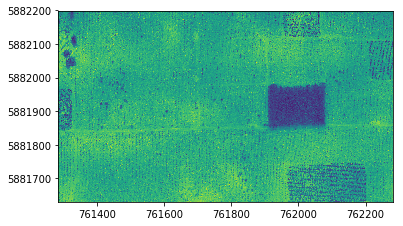

In [5]:
rasterio.plot.show(raster)

## Rotar Puntos

In [14]:
# puntos = gpd.read_file(shp)
# 761.774,565  5.881.886,945 Meters
# puntos = puntos.rotate(-48.01,origin=(761774.565,5881886.945))
# puntos.to_file(driver = 'ESRI Shapefile', filename = "puntos_rotados")
# puntos.plot()

## Cargar Mapa Densidad

In [31]:
# inicialemnte correr notebook mapa_densidad
mapa_densidad = np.load(url_salida+"/mapa_densidad" + '.npy')
print(np.sum(mapa_densidad),puntos.shape[0])

FileNotFoundError: [Errno 2] No such file or directory: 'train/11//mapa_densidad.npy'

In [8]:
plt.figure(figsize=(30,30))
print(mapa_densidad.shape)
plt.imshow(mapa_densidad)
# plt.colorbar()
plt.show()

NameError: name 'mapa_densidad' is not defined

<Figure size 2160x2160 with 0 Axes>

## Mapa densidad a shapefile

In [20]:
# output_file = 'density_map_final_final.shp'
# utilidades.array_to_shp(mapa_densidad,raster,output_file)

In [29]:
# ruta_1m = "D:/Memoria/Codigo/AraucoNursery/PROYECTOS/cortes/1m.png"
# mapa_densidad=mpimg.imread(ruta_1m)

In [20]:
offsetX = 0
offsetY = 0
width = 100
height = 100
step = 100
nulo = [65535]
#lista de imagenes
lista_imagenes = []
#lista del conteo
lista_etiquetas = []
#lista de los mapas de densidad
lista_mapa = []
contador = 0

## Proceso Cortado

In [21]:
# %%time
contador = 0
out_meta = raster.meta.copy()
while (1):
        # finalizar si se a recorrido toda la imagen
    if(offsetY >= raster.height and offsetX >= raster.width):
        break
     #cuando llegue al borde en el eje x, debo bajar(sumar en eje y) y debo volver a empezar setear offsetX en 0 y widthX en 100
    elif(offsetX >= raster.width):
        offsetY = offsetY + step
        offsetX = 0
        
    #entregamos los pixeles para obtener las coordenadas
    t = raster.xy(offsetX, offsetY)
    r = raster.xy(offsetX + width , offsetY)
    l = raster.xy(offsetX, offsetY + height)
    b = raster.xy(offsetX + width , offsetY + height)
    minx = min(t[0],l[0],b[0],t[0])
    maxx = max(t[0],l[0],b[0],t[0])
    miny = min(t[1],l[1],b[1],t[1])
    maxy = max(t[1],l[1],b[1],t[1])
    bbox = box(minx, miny, maxx, maxy)  
    
    try:

        #transformacion de la imagen
        out_img, out_transform = mask(raster, shapes=[bbox], crop=True)
        out_img = out_img[0:3,1:101,0:100]
        
#         out_meta.update({"driver": "GTiff",
#                             "height": 100,
#                             "width": 100,
#                             "transform": out_transform,
#                             "crs": raster.crs})
        
        #corte mapa densidad
#         corte= mapa_densidad[offsetX: offsetX + width , offsetY : offsetY + height]
        
#         interseccion ptos
        interseccion = puntos["geometry"].intersects(bbox)
        puntos_por_imagen = puntos[interseccion]
        cantidad = interseccion.value_counts()

        if(True in cantidad.index):
            numero = cantidad[True]
        else:
            numero = 0

        lista_imagenes.append(out_img.T)
#         lista_mapa.append(corte.T)
        lista_etiquetas.append(numero)
        contador = contador + 1

    except ValueError:
        pass
    offsetX = offsetX + step 

KeyboardInterrupt: 

In [26]:
lista_imagenes[0].shape

(100, 100, 3)

In [27]:
def list_to_np_array(in_list):
    max_h = 0
    max_w = 0
    for i, item in enumerate(in_list):
        if item.shape[0] > max_h:
            max_h = item.shape[0]
        if item.shape[1] > max_w:
            max_w = item.shape[1]
    out_arr = np.zeros((len(in_list), max_h, max_w, 3))
    for i, item in enumerate(in_list):
        pad_h = max_h - item.shape[0]
        pad_w = max_w - item.shape[1]
        out_arr[i] = np.pad(item, ((0,pad_h),(0,pad_w),(0,0)), mode='constant', constant_values=0.)
    return out_arr

In [38]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.figure(figsize=(30,30))
    plt.imshow(data)
    plt.axis('off')
    

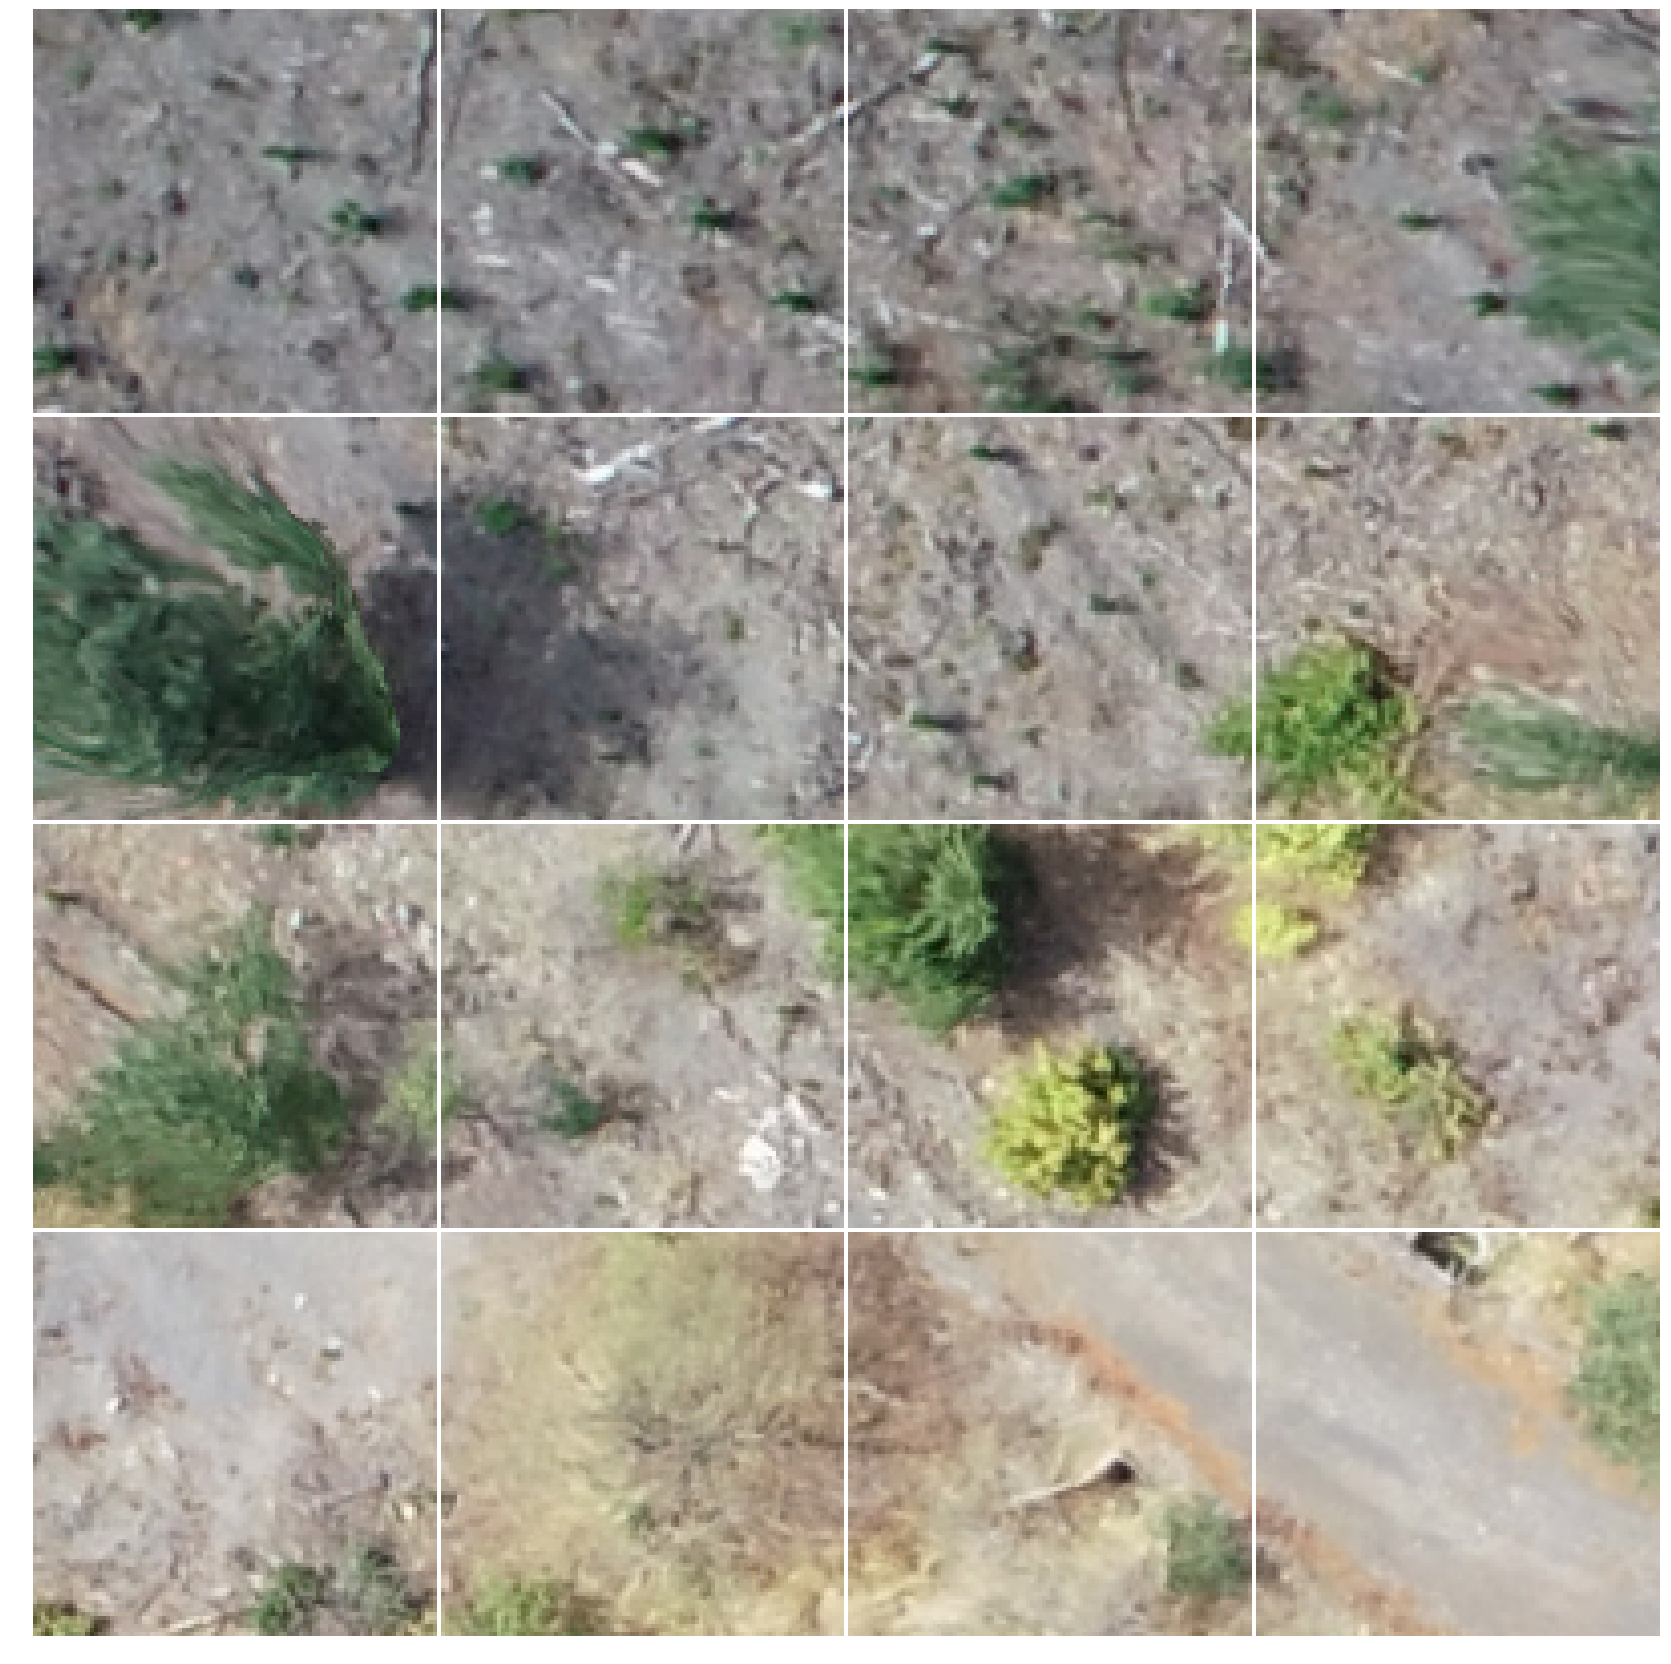

In [39]:
vis_square(list_to_np_array(lista_imagenes))

In [ ]:
# plt.figure()
# plt.imshow(lista_imagenes[7])

In [22]:
n_lista_imagenes = len(lista_imagenes)
n_lista_etiquetas = len(lista_etiquetas)
n_lista_mapa = len(lista_mapa)

In [23]:
lista_imagenes = np.array(lista_imagenes)
lista_etiquetas = np.array(lista_etiquetas)
lista_mapa = np.array(lista_mapa)

In [24]:
HEIGHT = 100
WIDTH = 100
CHANNELS = 3
factor_reduccion= 4

In [25]:
densidades = utilidades.reduccion_mapa(lista_mapa,factor_reduccion)

In [26]:
hf = h5py.File(archivo_h5_mapa, 'w')

In [27]:
%%time
Xset = hf.create_dataset(
        name= "images",
        data=lista_imagenes,
        shape=(n_lista_imagenes,HEIGHT, WIDTH, CHANNELS),
        compression="gzip",
        compression_opts=9)

Wall time: 1min 14s


In [28]:
%%time
Yset = hf.create_dataset(
        name= "density",
        data=lista_mapa,
        shape=(n_lista_mapa,HEIGHT,WIDTH),
        compression="gzip",
        compression_opts=9)


Wall time: 9.66 s


In [29]:
%%time
Zset = hf.create_dataset(
        name= "counts",
        data=lista_etiquetas,
        shape=(n_lista_mapa,),
        compression="gzip",
        compression_opts=9)


Wall time: 991 µs


In [30]:
Vset = hf.create_dataset(
        name= "reduced_density",
        data=densidades,
        shape=(n_lista_mapa,HEIGHT/factor_reduccion,WIDTH/factor_reduccion),
        compression="gzip",
        compression_opts=9)

In [31]:
hf.close()

# Revision de los datos

In [19]:
numero = 1001

with h5py.File('./train/9/data_mapa.h5', 'r') as hf:
    imagen = hf["images"][numero]
    densidad = hf["density"][numero]
    densidad_chica =hf["density_model"][numero]

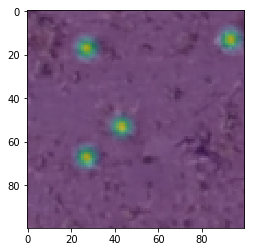

In [24]:
plt.figure()
plt.imshow(imagen)
plt.imshow(densidad, alpha=0.55)

In [38]:
unique, counts = np.unique(lista_etiquetas, return_counts=True)
print(np.asarray((unique, counts)).T)

[[  1 213]
 [  2 419]
 [  3 683]
 [  4 909]
 [  5 913]
 [  6 989]
 [  7 850]
 [  8 480]
 [  9  96]
 [ 10  12]
 [ 11   1]]


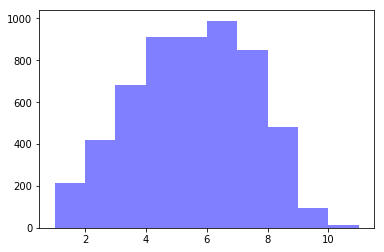

In [40]:
n, bins, patches = plt.hist(lista_etiquetas, unique, facecolor='blue', alpha=0.5)